# **1. Matériel : vérifier que le GPU est bien sélectionné**

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 14 12:03:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              30W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **2. Importation des librairies**

In [2]:
import sys,os
import torch, torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
from torchsummary import summary

from torch import Tensor
from functools import partial

from torchvision.transforms._presets import ImageClassification
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# **3. Importation des données**

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
folder='/content/drive/MyDrive/Workshop/' #@param ['/content/drive/MyDrive/Workshop/','/content/drive/MyDrive/IA/UMONS/Workshop/']

image_classification_path = f'{folder}2. Image classification'

training_path=   image_classification_path + '/' + 'data'
testing_path = image_classification_path + '/' + 'test'
sys.path.append(image_classification_path)
os.chdir(image_classification_path)


Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **4. Paramètres**

In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [31]:
batch_size=16 #@param [16,32]
validation_split = 0.1
seed = 50 #@param
classifier='ResNet50v2' #@param ['ResNet50v2']
#base_model = models.resnet50(pretrained=True)

# Assuming 'num_classes' is the number of classes in your dataset
num_classes = 3  # You have three classes: fire, start fire, no_fire

if classifier == 'ResNet50v2':
    weights = ResNet50_Weights.DEFAULT
    base_model = models.resnet50(weights=weights)
    base_model = base_model.to(device)  # Move the model to the appropriate device

    # Freeze all layers in the network
    for param in base_model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer with a new one (unfrozen by default)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Linear(num_ftrs, num_classes)

    preprocess = weights.transforms()

# **5. Visualiser une image**

In [32]:
transformView = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    #transforms.RandomRotation(15),       # Randomly rotate the images by +/- 15 degrees
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

datasetView = datasets.ImageFolder(training_path, transformView)
dataloaderView = torch.utils.data.DataLoader(datasetView, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(root=testing_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [33]:
from collections import Counter

# Count the number of instances per class
class_counts = Counter(datasetView.targets)
total_images = len(datasetView)

# Calculate the proportion of each class
class_proportions = {datasetView.classes[i]: count / total_images for i, count in class_counts.items()}

# Print the class proportions
print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")

Class Proportions:
fire: 0.39
no_fire: 0.30
start_fire: 0.30


In [34]:
from torch.utils.data import random_split

total_size = len(datasetView)
train_size = int(total_size * (1 - validation_split))
validation_size = total_size - train_size

torch.manual_seed(seed)
train_dataset, validation_dataset = random_split(datasetView, [train_size, validation_size])

# Create DataLoaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

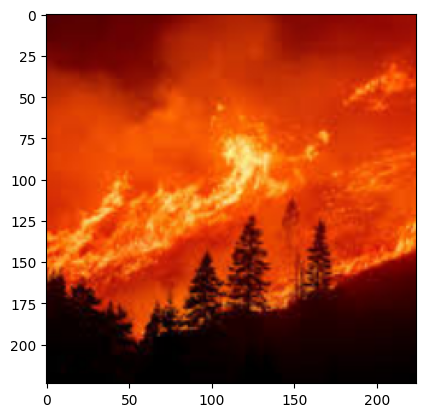

In [35]:
images,labels = next(iter(dataloaderView))
imshow(images[0].permute(1, 2, 0))

In [36]:
import torch
import torch.nn as nn
from torchvision import models

def create_model(num_classes):
    # Load a pre-trained ResNet18 model
    model = models.resnet152(pretrained=True)

    # Freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer with a new one with `num_classes` outputs
    num_ftrs = model.fc.in_features
    # Create a new classifier with additional layers
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(32, num_classes),  # Use num_classes here to make it flexible
        nn.Softmax(dim=1)
    )

    return model

model = create_model(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [38]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.fc.parameters(), lr=0.001)  # Optimize only the last layer

import torch

def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=3):
    model.to(device)  # Ensure model is on the correct device
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                validation_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss /= len(validation_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%')

        test_loss, test_accuracy = evaluate_model(model, train_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return model

# Assuming base_model is defined and set up correctly with the final layers as needed
# Assuming train_loader and validation_loader are defined and loaded with the appropriate datasets
model = train_model(base_model, train_loader, validation_loader, criterion, optimizer, num_epochs=3)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/3, Train Loss: 0.5684, Train Acc: 82.59%, Validation Loss: 0.4241, Validation Acc: 84.50%
Test Loss: 0.3359, Test Accuracy: 90.21%
Epoch 2/3, Train Loss: 0.3394, Train Acc: 88.82%, Validation Loss: 0.3774, Validation Acc: 85.50%
Test Loss: 0.2496, Test Accuracy: 92.71%
Epoch 3/3, Train Loss: 0.2948, Train Acc: 90.66%, Validation Loss: 0.3613, Validation Acc: 88.50%
Test Loss: 0.2239, Test Accuracy: 93.77%


In [24]:
test_loss, test_accuracy = evaluate_model(model, train_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.1500, Test Accuracy: 96.11%


In [39]:
torch.save(model, 'model.pth')

In [28]:
model = create_model(3)
model.load_state_dict(torch.load('model.pth'))  # Load the saved state dictionary
model.eval()

test_loss, test_accuracy = evaluate_model(model, train_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "layer2.4.conv1.weight", "layer2.4.bn1.weight", "layer2.4.bn1.bias", "layer2.4.bn1.running_mean", "layer2.4.bn1.running_var", "layer2.4.conv2.weight", "layer2.4.bn2.weight", "layer2.4.bn2.bias", "layer2.4.bn2.running_mean", "layer2.4.bn2.running_var", "layer2.4.conv3.weight", "layer2.4.bn3.weight", "layer2.4.bn3.bias", "layer2.4.bn3.running_mean", "layer2.4.bn3.running_var", "layer2.5.conv1.weight", "layer2.5.bn1.weight", "layer2.5.bn1.bias", "layer2.5.bn1.running_mean", "layer2.5.bn1.running_var", "layer2.5.conv2.weight", "layer2.5.bn2.weight", "layer2.5.bn2.bias", "layer2.5.bn2.running_mean", "layer2.5.bn2.running_var", "layer2.5.conv3.weight", "layer2.5.bn3.weight", "layer2.5.bn3.bias", "layer2.5.bn3.running_mean", "layer2.5.bn3.running_var", "layer2.6.conv1.weight", "layer2.6.bn1.weight", "layer2.6.bn1.bias", "layer2.6.bn1.running_mean", "layer2.6.bn1.running_var", "layer2.6.conv2.weight", "layer2.6.bn2.weight", "layer2.6.bn2.bias", "layer2.6.bn2.running_mean", "layer2.6.bn2.running_var", "layer2.6.conv3.weight", "layer2.6.bn3.weight", "layer2.6.bn3.bias", "layer2.6.bn3.running_mean", "layer2.6.bn3.running_var", "layer2.7.conv1.weight", "layer2.7.bn1.weight", "layer2.7.bn1.bias", "layer2.7.bn1.running_mean", "layer2.7.bn1.running_var", "layer2.7.conv2.weight", "layer2.7.bn2.weight", "layer2.7.bn2.bias", "layer2.7.bn2.running_mean", "layer2.7.bn2.running_var", "layer2.7.conv3.weight", "layer2.7.bn3.weight", "layer2.7.bn3.bias", "layer2.7.bn3.running_mean", "layer2.7.bn3.running_var", "layer3.6.conv1.weight", "layer3.6.bn1.weight", "layer3.6.bn1.bias", "layer3.6.bn1.running_mean", "layer3.6.bn1.running_var", "layer3.6.conv2.weight", "layer3.6.bn2.weight", "layer3.6.bn2.bias", "layer3.6.bn2.running_mean", "layer3.6.bn2.running_var", "layer3.6.conv3.weight", "layer3.6.bn3.weight", "layer3.6.bn3.bias", "layer3.6.bn3.running_mean", "layer3.6.bn3.running_var", "layer3.7.conv1.weight", "layer3.7.bn1.weight", "layer3.7.bn1.bias", "layer3.7.bn1.running_mean", "layer3.7.bn1.running_var", "layer3.7.conv2.weight", "layer3.7.bn2.weight", "layer3.7.bn2.bias", "layer3.7.bn2.running_mean", "layer3.7.bn2.running_var", "layer3.7.conv3.weight", "layer3.7.bn3.weight", "layer3.7.bn3.bias", "layer3.7.bn3.running_mean", "layer3.7.bn3.running_var", "layer3.8.conv1.weight", "layer3.8.bn1.weight", "layer3.8.bn1.bias", "layer3.8.bn1.running_mean", "layer3.8.bn1.running_var", "layer3.8.conv2.weight", "layer3.8.bn2.weight", "layer3.8.bn2.bias", "layer3.8.bn2.running_mean", "layer3.8.bn2.running_var", "layer3.8.conv3.weight", "layer3.8.bn3.weight", "layer3.8.bn3.bias", "layer3.8.bn3.running_mean", "layer3.8.bn3.running_var", "layer3.9.conv1.weight", "layer3.9.bn1.weight", "layer3.9.bn1.bias", "layer3.9.bn1.running_mean", "layer3.9.bn1.running_var", "layer3.9.conv2.weight", "layer3.9.bn2.weight", "layer3.9.bn2.bias", "layer3.9.bn2.running_mean", "layer3.9.bn2.running_var", "layer3.9.conv3.weight", "layer3.9.bn3.weight", "layer3.9.bn3.bias", "layer3.9.bn3.running_mean", "layer3.9.bn3.running_var", "layer3.10.conv1.weight", "layer3.10.bn1.weight", "layer3.10.bn1.bias", "layer3.10.bn1.running_mean", "layer3.10.bn1.running_var", "layer3.10.conv2.weight", "layer3.10.bn2.weight", "layer3.10.bn2.bias", "layer3.10.bn2.running_mean", "layer3.10.bn2.running_var", "layer3.10.conv3.weight", "layer3.10.bn3.weight", "layer3.10.bn3.bias", "layer3.10.bn3.running_mean", "layer3.10.bn3.running_var", "layer3.11.conv1.weight", "layer3.11.bn1.weight", "layer3.11.bn1.bias", "layer3.11.bn1.running_mean", "layer3.11.bn1.running_var", "layer3.11.conv2.weight", "layer3.11.bn2.weight", "layer3.11.bn2.bias", "layer3.11.bn2.running_mean", "layer3.11.bn2.running_var", "layer3.11.conv3.weight", "layer3.11.bn3.weight", "layer3.11.bn3.bias", "layer3.11.bn3.running_mean", "layer3.11.bn3.running_var", "layer3.12.conv1.weight", "layer3.12.bn1.weight", "layer3.12.bn1.bias", "layer3.12.bn1.running_mean", "layer3.12.bn1.running_var", "layer3.12.conv2.weight", "layer3.12.bn2.weight", "layer3.12.bn2.bias", "layer3.12.bn2.running_mean", "layer3.12.bn2.running_var", "layer3.12.conv3.weight", "layer3.12.bn3.weight", "layer3.12.bn3.bias", "layer3.12.bn3.running_mean", "layer3.12.bn3.running_var", "layer3.13.conv1.weight", "layer3.13.bn1.weight", "layer3.13.bn1.bias", "layer3.13.bn1.running_mean", "layer3.13.bn1.running_var", "layer3.13.conv2.weight", "layer3.13.bn2.weight", "layer3.13.bn2.bias", "layer3.13.bn2.running_mean", "layer3.13.bn2.running_var", "layer3.13.conv3.weight", "layer3.13.bn3.weight", "layer3.13.bn3.bias", "layer3.13.bn3.running_mean", "layer3.13.bn3.running_var", "layer3.14.conv1.weight", "layer3.14.bn1.weight", "layer3.14.bn1.bias", "layer3.14.bn1.running_mean", "layer3.14.bn1.running_var", "layer3.14.conv2.weight", "layer3.14.bn2.weight", "layer3.14.bn2.bias", "layer3.14.bn2.running_mean", "layer3.14.bn2.running_var", "layer3.14.conv3.weight", "layer3.14.bn3.weight", "layer3.14.bn3.bias", "layer3.14.bn3.running_mean", "layer3.14.bn3.running_var", "layer3.15.conv1.weight", "layer3.15.bn1.weight", "layer3.15.bn1.bias", "layer3.15.bn1.running_mean", "layer3.15.bn1.running_var", "layer3.15.conv2.weight", "layer3.15.bn2.weight", "layer3.15.bn2.bias", "layer3.15.bn2.running_mean", "layer3.15.bn2.running_var", "layer3.15.conv3.weight", "layer3.15.bn3.weight", "layer3.15.bn3.bias", "layer3.15.bn3.running_mean", "layer3.15.bn3.running_var", "layer3.16.conv1.weight", "layer3.16.bn1.weight", "layer3.16.bn1.bias", "layer3.16.bn1.running_mean", "layer3.16.bn1.running_var", "layer3.16.conv2.weight", "layer3.16.bn2.weight", "layer3.16.bn2.bias", "layer3.16.bn2.running_mean", "layer3.16.bn2.running_var", "layer3.16.conv3.weight", "layer3.16.bn3.weight", "layer3.16.bn3.bias", "layer3.16.bn3.running_mean", "layer3.16.bn3.running_var", "layer3.17.conv1.weight", "layer3.17.bn1.weight", "layer3.17.bn1.bias", "layer3.17.bn1.running_mean", "layer3.17.bn1.running_var", "layer3.17.conv2.weight", "layer3.17.bn2.weight", "layer3.17.bn2.bias", "layer3.17.bn2.running_mean", "layer3.17.bn2.running_var", "layer3.17.conv3.weight", "layer3.17.bn3.weight", "layer3.17.bn3.bias", "layer3.17.bn3.running_mean", "layer3.17.bn3.running_var", "layer3.18.conv1.weight", "layer3.18.bn1.weight", "layer3.18.bn1.bias", "layer3.18.bn1.running_mean", "layer3.18.bn1.running_var", "layer3.18.conv2.weight", "layer3.18.bn2.weight", "layer3.18.bn2.bias", "layer3.18.bn2.running_mean", "layer3.18.bn2.running_var", "layer3.18.conv3.weight", "layer3.18.bn3.weight", "layer3.18.bn3.bias", "layer3.18.bn3.running_mean", "layer3.18.bn3.running_var", "layer3.19.conv1.weight", "layer3.19.bn1.weight", "layer3.19.bn1.bias", "layer3.19.bn1.running_mean", "layer3.19.bn1.running_var", "layer3.19.conv2.weight", "layer3.19.bn2.weight", "layer3.19.bn2.bias", "layer3.19.bn2.running_mean", "layer3.19.bn2.running_var", "layer3.19.conv3.weight", "layer3.19.bn3.weight", "layer3.19.bn3.bias", "layer3.19.bn3.running_mean", "layer3.19.bn3.running_var", "layer3.20.conv1.weight", "layer3.20.bn1.weight", "layer3.20.bn1.bias", "layer3.20.bn1.running_mean", "layer3.20.bn1.running_var", "layer3.20.conv2.weight", "layer3.20.bn2.weight", "layer3.20.bn2.bias", "layer3.20.bn2.running_mean", "layer3.20.bn2.running_var", "layer3.20.conv3.weight", "layer3.20.bn3.weight", "layer3.20.bn3.bias", "layer3.20.bn3.running_mean", "layer3.20.bn3.running_var", "layer3.21.conv1.weight", "layer3.21.bn1.weight", "layer3.21.bn1.bias", "layer3.21.bn1.running_mean", "layer3.21.bn1.running_var", "layer3.21.conv2.weight", "layer3.21.bn2.weight", "layer3.21.bn2.bias", "layer3.21.bn2.running_mean", "layer3.21.bn2.running_var", "layer3.21.conv3.weight", "layer3.21.bn3.weight", "layer3.21.bn3.bias", "layer3.21.bn3.running_mean", "layer3.21.bn3.running_var", "layer3.22.conv1.weight", "layer3.22.bn1.weight", "layer3.22.bn1.bias", "layer3.22.bn1.running_mean", "layer3.22.bn1.running_var", "layer3.22.conv2.weight", "layer3.22.bn2.weight", "layer3.22.bn2.bias", "layer3.22.bn2.running_mean", "layer3.22.bn2.running_var", "layer3.22.conv3.weight", "layer3.22.bn3.weight", "layer3.22.bn3.bias", "layer3.22.bn3.running_mean", "layer3.22.bn3.running_var", "layer3.23.conv1.weight", "layer3.23.bn1.weight", "layer3.23.bn1.bias", "layer3.23.bn1.running_mean", "layer3.23.bn1.running_var", "layer3.23.conv2.weight", "layer3.23.bn2.weight", "layer3.23.bn2.bias", "layer3.23.bn2.running_mean", "layer3.23.bn2.running_var", "layer3.23.conv3.weight", "layer3.23.bn3.weight", "layer3.23.bn3.bias", "layer3.23.bn3.running_mean", "layer3.23.bn3.running_var", "layer3.24.conv1.weight", "layer3.24.bn1.weight", "layer3.24.bn1.bias", "layer3.24.bn1.running_mean", "layer3.24.bn1.running_var", "layer3.24.conv2.weight", "layer3.24.bn2.weight", "layer3.24.bn2.bias", "layer3.24.bn2.running_mean", "layer3.24.bn2.running_var", "layer3.24.conv3.weight", "layer3.24.bn3.weight", "layer3.24.bn3.bias", "layer3.24.bn3.running_mean", "layer3.24.bn3.running_var", "layer3.25.conv1.weight", "layer3.25.bn1.weight", "layer3.25.bn1.bias", "layer3.25.bn1.running_mean", "layer3.25.bn1.running_var", "layer3.25.conv2.weight", "layer3.25.bn2.weight", "layer3.25.bn2.bias", "layer3.25.bn2.running_mean", "layer3.25.bn2.running_var", "layer3.25.conv3.weight", "layer3.25.bn3.weight", "layer3.25.bn3.bias", "layer3.25.bn3.running_mean", "layer3.25.bn3.running_var", "layer3.26.conv1.weight", "layer3.26.bn1.weight", "layer3.26.bn1.bias", "layer3.26.bn1.running_mean", "layer3.26.bn1.running_var", "layer3.26.conv2.weight", "layer3.26.bn2.weight", "layer3.26.bn2.bias", "layer3.26.bn2.running_mean", "layer3.26.bn2.running_var", "layer3.26.conv3.weight", "layer3.26.bn3.weight", "layer3.26.bn3.bias", "layer3.26.bn3.running_mean", "layer3.26.bn3.running_var", "layer3.27.conv1.weight", "layer3.27.bn1.weight", "layer3.27.bn1.bias", "layer3.27.bn1.running_mean", "layer3.27.bn1.running_var", "layer3.27.conv2.weight", "layer3.27.bn2.weight", "layer3.27.bn2.bias", "layer3.27.bn2.running_mean", "layer3.27.bn2.running_var", "layer3.27.conv3.weight", "layer3.27.bn3.weight", "layer3.27.bn3.bias", "layer3.27.bn3.running_mean", "layer3.27.bn3.running_var", "layer3.28.conv1.weight", "layer3.28.bn1.weight", "layer3.28.bn1.bias", "layer3.28.bn1.running_mean", "layer3.28.bn1.running_var", "layer3.28.conv2.weight", "layer3.28.bn2.weight", "layer3.28.bn2.bias", "layer3.28.bn2.running_mean", "layer3.28.bn2.running_var", "layer3.28.conv3.weight", "layer3.28.bn3.weight", "layer3.28.bn3.bias", "layer3.28.bn3.running_mean", "layer3.28.bn3.running_var", "layer3.29.conv1.weight", "layer3.29.bn1.weight", "layer3.29.bn1.bias", "layer3.29.bn1.running_mean", "layer3.29.bn1.running_var", "layer3.29.conv2.weight", "layer3.29.bn2.weight", "layer3.29.bn2.bias", "layer3.29.bn2.running_mean", "layer3.29.bn2.running_var", "layer3.29.conv3.weight", "layer3.29.bn3.weight", "layer3.29.bn3.bias", "layer3.29.bn3.running_mean", "layer3.29.bn3.running_var", "layer3.30.conv1.weight", "layer3.30.bn1.weight", "layer3.30.bn1.bias", "layer3.30.bn1.running_mean", "layer3.30.bn1.running_var", "layer3.30.conv2.weight", "layer3.30.bn2.weight", "layer3.30.bn2.bias", "layer3.30.bn2.running_mean", "layer3.30.bn2.running_var", "layer3.30.conv3.weight", "layer3.30.bn3.weight", "layer3.30.bn3.bias", "layer3.30.bn3.running_mean", "layer3.30.bn3.running_var", "layer3.31.conv1.weight", "layer3.31.bn1.weight", "layer3.31.bn1.bias", "layer3.31.bn1.running_mean", "layer3.31.bn1.running_var", "layer3.31.conv2.weight", "layer3.31.bn2.weight", "layer3.31.bn2.bias", "layer3.31.bn2.running_mean", "layer3.31.bn2.running_var", "layer3.31.conv3.weight", "layer3.31.bn3.weight", "layer3.31.bn3.bias", "layer3.31.bn3.running_mean", "layer3.31.bn3.running_var", "layer3.32.conv1.weight", "layer3.32.bn1.weight", "layer3.32.bn1.bias", "layer3.32.bn1.running_mean", "layer3.32.bn1.running_var", "layer3.32.conv2.weight", "layer3.32.bn2.weight", "layer3.32.bn2.bias", "layer3.32.bn2.running_mean", "layer3.32.bn2.running_var", "layer3.32.conv3.weight", "layer3.32.bn3.weight", "layer3.32.bn3.bias", "layer3.32.bn3.running_mean", "layer3.32.bn3.running_var", "layer3.33.conv1.weight", "layer3.33.bn1.weight", "layer3.33.bn1.bias", "layer3.33.bn1.running_mean", "layer3.33.bn1.running_var", "layer3.33.conv2.weight", "layer3.33.bn2.weight", "layer3.33.bn2.bias", "layer3.33.bn2.running_mean", "layer3.33.bn2.running_var", "layer3.33.conv3.weight", "layer3.33.bn3.weight", "layer3.33.bn3.bias", "layer3.33.bn3.running_mean", "layer3.33.bn3.running_var", "layer3.34.conv1.weight", "layer3.34.bn1.weight", "layer3.34.bn1.bias", "layer3.34.bn1.running_mean", "layer3.34.bn1.running_var", "layer3.34.conv2.weight", "layer3.34.bn2.weight", "layer3.34.bn2.bias", "layer3.34.bn2.running_mean", "layer3.34.bn2.running_var", "layer3.34.conv3.weight", "layer3.34.bn3.weight", "layer3.34.bn3.bias", "layer3.34.bn3.running_mean", "layer3.34.bn3.running_var", "layer3.35.conv1.weight", "layer3.35.bn1.weight", "layer3.35.bn1.bias", "layer3.35.bn1.running_mean", "layer3.35.bn1.running_var", "layer3.35.conv2.weight", "layer3.35.bn2.weight", "layer3.35.bn2.bias", "layer3.35.bn2.running_mean", "layer3.35.bn2.running_var", "layer3.35.conv3.weight", "layer3.35.bn3.weight", "layer3.35.bn3.bias", "layer3.35.bn3.running_mean", "layer3.35.bn3.running_var", "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias", "fc.6.weight", "fc.6.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

In [26]:
from torchvision import transforms
from PIL import Image

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Load an image
image_path = '/content/drive/MyDrive/Workshop/2. Image classification/data/fire/00000050.jpg'
input_image = Image.open(image_path)

# Preprocess the image
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Make a prediction
with torch.no_grad():
    output = model(input_batch)

print(output)

tensor([[ 1.4699, -3.7615, -2.1005]], device='cuda:0')


# **6. Visualiser une image préparée pour le modèle de base**

In [ ]:
#ancien

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

dataset = datasets.ImageFolder(training_path,preprocess)

# generate indices: instead of the actual data we pass in integers instead
#train_indices, valid_indices, _, _ = train_test_split(
    #range(len(dataset)),
    #dataset.targets,
    #stratify=dataset.targets,
    #test_size=validation_split,
    #random_state=seed
#)

train_indices, valid_indices, _, _ = train_test_split(
    np.arange(dataset.targets),
    dataset.targets,
    stratify=dataset.targets,
    test_size=validation_split,
    random_state=seed
)

# generate subset based on indices
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, valid_indices)

# create batches
dataloader={}
dataloader['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader['validation']  = DataLoader(validation_dataset, batch_size=batch_size)

In [ ]:
dataset = datasets.ImageFolder(training_path,preprocess)
generator1 = torch.Generator().manual_seed(seed)
dataloader={}
dataset= torch.utils.data.random_split(dataset, [0.8,0.2],generator=generator1)
dataset={'train':dataset[0],'validation':dataset[1]}
dataloader = {'train':DataLoader(dataset=dataset['train'], shuffle=True, batch_size=batch_size, drop_last=True),
                'validation':DataLoader(dataset=dataset['validation'], shuffle=False, batch_size=batch_size)
}
print(len(dataloader['train']),len(dataloader['validation']))




In [ ]:
images,labels = next(iter(dataloader['train']))
print(images[0])
imshow(images[0].permute(1, 2, 0))
#imshow(images[0])
print(labels[0])

# **7. Construction du modèle**

In [ ]:
#ancien

class Model(nn.Module):
  def __init__(self):
      super().__init__()
      self.base_model = base_model
      for param in self.base_model.parameters():
        param.requires_grad = False
      self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3,inplace=True),
            nn.Linear(1024, 3),
            nn.Softmax()
            )

  def forward(self,x):
    self.to(device)
    x = self.fc(self.base_model(x))
    return x

model=Model()


In [ ]:
del model
model=base_model
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
              nn.Linear(2048, 1024),
              nn.ReLU(inplace=True),
              nn.Dropout(p=0.3),
              nn.Linear(1024, 3),
              nn.Softmax(-1)
              )
model=model.to(device)
criterion = nn.CrossEntropyLoss()


# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
summary(model, (3, 224, 224))

In [ ]:
print(model)

# **8. Entraînement du modèle**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
              scheduler.step()

            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = running_corrects.double() / len(dataset[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=12)

# **Brouillon**

In [ ]:
#pour avoir la distribution des classes
print(dataset.class_to_idx)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(idx_to_class)
def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in dataset.class_to_idx.items()} # initialise dictionary

    for input, label in dataset:
        label = idx_to_class[label]
        count_dict[label] += 1

    return count_dict

print("Distribution of classes: ", get_class_distribution(dataset))

In [ ]:
class Model(nn.Module):
  def __init__(self, backbone):
      super().__init__()
      self.pretrained_model = None
      self.classifier_layers = []
      self.new_layers = []

      self.pretrained_model = base_model
      self.classifier_layers = [self.pretrained_model.fc]
      self.pretrained_model.fc = nn.Linear(
          in_features=2048, out_features=3, bias=True
      )
      self.pretrained_model.fc = nn.Sequential(
          torch.nn.AvgPool2d(kernel_size = 100, stride = 0, padding = 0, ceil_mode=False, count_include_pad=True),
          nn.Linear(1024, 512),


      out_features=3, bias=True
      )
      x = torch.nn.AvgPool2d(kernel_size = 100, stride = 0, padding = 0, ceil_mode=False, count_include_pad=True)(x)
      self.new_layers = [self.pretrained_model.fc]

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

  def freezing(self):
    for p in self.pretrained_model:
      p.requires_grad = False
    for l in self.new_layers:
      for p in l.parameters():
          p.requires_grad = True

  def get_optimizer_params(self):
    """This method is used only during model fine-tuning when we need to
    set a linearly or exponentially decaying learning rate (LR) for the
    layers in the model. We exponentially decay the learning rate as we
    move away from the last output layer.
    """
    options = []
    # For the resnet class of models, we decay the LR exponentially and reduce
    # it to a third of the previous value at each step.
    layers = ["conv1", "bn1", "layer1", "layer2", "layer3", "layer4", "fc"]
    lr = 0.0001
    for layer_name in reversed(layers):
        options.append(
            {
                "params": getattr(self.pretrained_model, layer_name).parameters(),
                "lr": lr,
            }
        )
        lr = lr / 3.0
    # end for
    return options

In [ ]:
optimizer = torch.optim.Adam(fc.get_optimizer_params(), lr=1e-8)

In [ ]:
class Model(nn.Module):
  def __init__(self):
    self.conv1 = base_model

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
dataset = datasets.ImageFolder(training_path,preprocess)
dataloaders = {
    'train':
    torch.utils.data.DataLoader(dataset['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

In [ ]:
next(iter(dataloader))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')